<a href="https://colab.research.google.com/github/priontu/Developing-a-Flower-Predictor-using-Keras-on-Tensorflow-and-ImageNet-models/blob/main/flower_predictor_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# dir(keras.applications) #Checking which engines are available/possible

In [ ]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = True)

91884032/91884032 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
trainSet, info = tfds.load(name='oxford_flowers102', split='train+validation', as_supervised=True, with_info=True)
validSet = tfds.load(name='oxford_flowers102', split='test[90%:]', as_supervised=True)
testSet = tfds.load(name='oxford_flowers102', split='test[:90%]', as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteI4DQR0/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteI4DQR0/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteI4DQR0/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
# info.features['label'].names

In [ ]:
# info

In [ ]:
nToAugment = 4
def augmentImages(image, label):
  resized_image = tf.image.resize_with_pad(image, 299, 299)
  imageL = [resized_image]
  myGen=keras.preprocessing.image.ImageDataGenerator(rotation_range=40, width_shift_range=[-.2,.2], brightness_range=[.6,1.0], shear_range=0.0, channel_shift_range=0.0, fill_mode='constant', cval=0.0, horizontal_flip=True, vertical_flip=True)
  augmented_images=[next(myGen.flow(resized_image)) for _ in range(nToAugment)]
  labels= [label.numpy() for _ in range(nToAugment+1)]
  imageL.extend(augmented_images)
  return imageL, labels

def augmentImagesTF(image, labels):
  func = tf.py_function(augmentImages, [image, labels], [tf.float32, tf.int32])
  return func

def mySqueeze(x, y):
  return tf.squeeze(x), y


In [ ]:
trainPipeAug = trainSet.batch(1).prefetch(1).map(augmentImagesTF, num_parallel_calls=16).unbatch().map(mySqueeze, num_parallel_calls=16).shuffle(512)

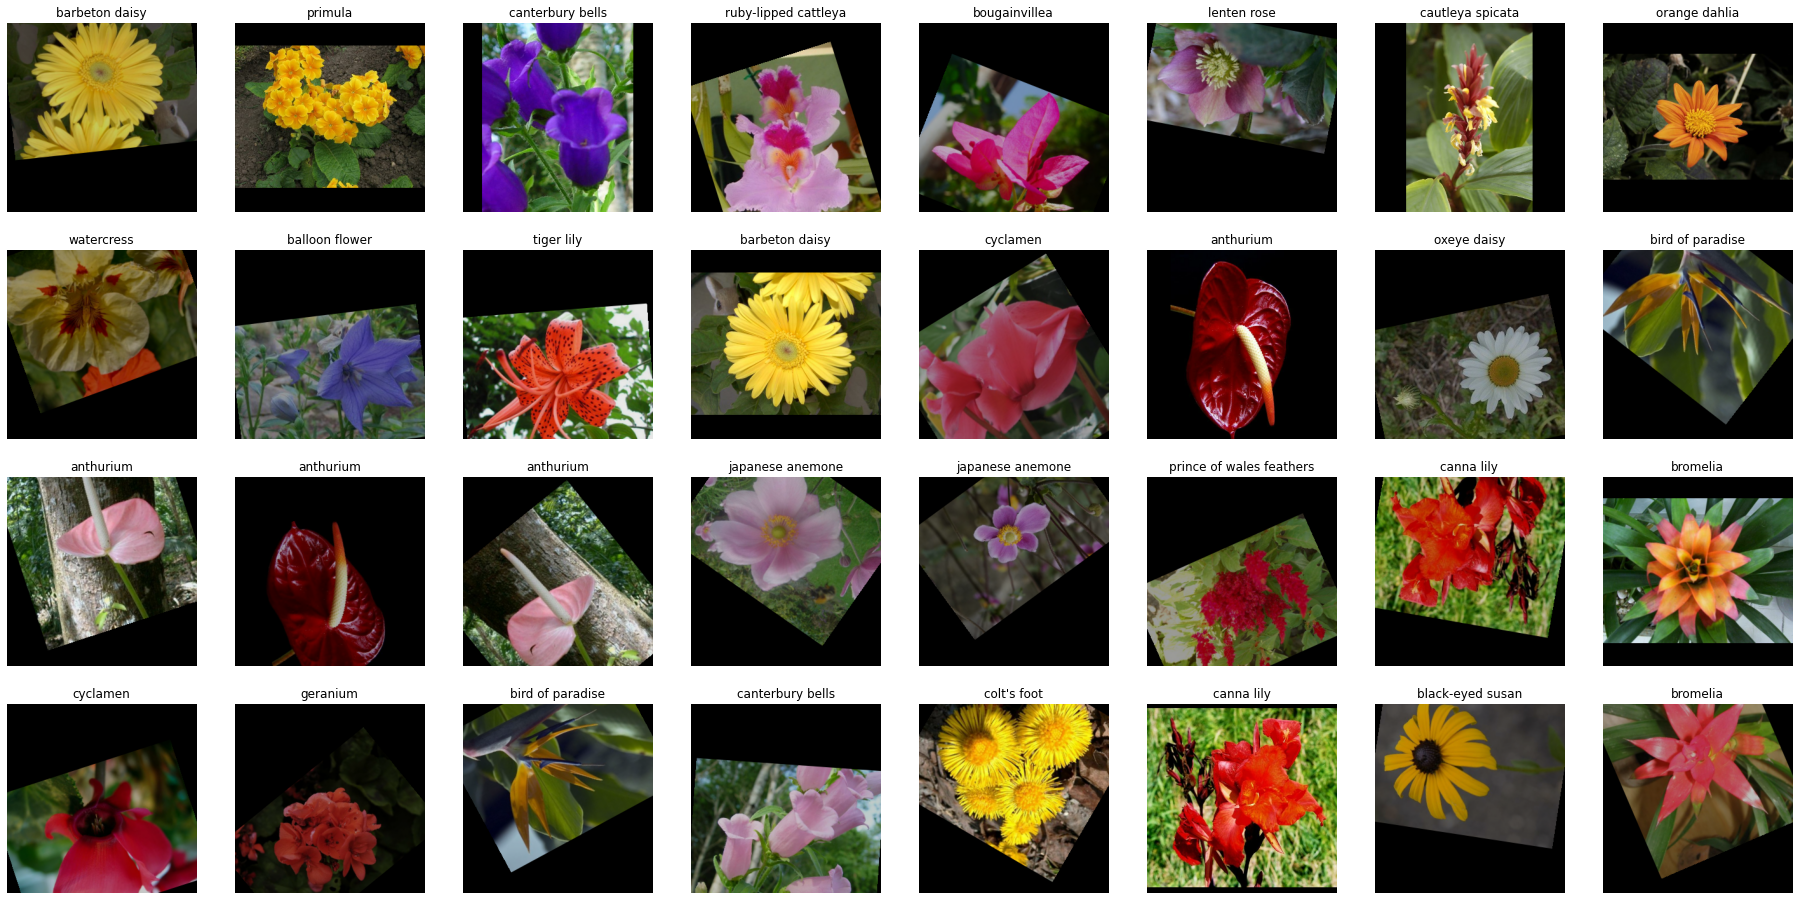

In [ ]:
cnt = 1
plt.figure(figsize=(32, 16))
for inst in trainPipeAug.take(4*8):
  plt.subplot(4,8,cnt)
  plt.imshow(inst[0].numpy()/255)
  plt.axis('off')
  plt.title(info.features['label'].names[inst[1][0]])
  cnt = cnt + 1

In [ ]:
def preproc(image, label):
  inp=keras.applications.xception.preprocess_input(image)
  return inp, label

def preprocessWithAspectRatio(image, label):
  resized_image=tf.image.resize_with_pad(image, 299, 299)
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

trainPipe=trainSet.map(preprocessWithAspectRatio, num_parallel_calls=8).batch(128).prefetch(1)
validPipe = validSet.map(preprocessWithAspectRatio, num_parallel_calls=8).batch(128).prefetch(1)
testPipe = testSet.map(preprocessWithAspectRatio, num_parallel_calls=8).batch(128).prefetch(1)


In [ ]:
# base_model.layers[:-1]

In [ ]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = False)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [ ]:
base_model.output

<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [ ]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
base_model.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>]

In [ ]:
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(info.features['label'].num_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.inputs, outputs=output) # base_model.inputs or input?
# model.summary()

In [ ]:
for layer in model.layers[:-2]:
  layer.trainable = False

# for layer in model.layers:
#   print(layer.trainable)

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('oxFLowersMod-topFit.h5', save_best_only=True)

earlyStop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)
ss=5e-1
# ss = 5
optimizer = keras.optimizers.SGD(learning_rate=ss)

model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
model.fit(trainPipe, validation_data= validPipe, epochs = 25, callbacks=[checkpoint_cb, earlyStop_cb])


Epoch 1/25
16/16 [==============================] - 23s 1s/step - loss: 4.2095 - accuracy: 0.1402 - val_loss: 3.6215 - val_accuracy: 0.3512
Epoch 2/25
16/16 [==============================] - 21s 1s/step - loss: 3.1818 - accuracy: 0.4711 - val_loss: 2.8878 - val_accuracy: 0.5561
Epoch 3/25
16/16 [==============================] - 21s 1s/step - loss: 2.4624 - accuracy: 0.6608 - val_loss: 2.3753 - val_accuracy: 0.6390
Epoch 4/25
16/16 [==============================] - 22s 1s/step - loss: 1.9689 - accuracy: 0.7667 - val_loss: 2.0181 - val_accuracy: 0.7041
Epoch 5/25
16/16 [==============================] - 21s 1s/step - loss: 1.6240 - accuracy: 0.8294 - val_loss: 1.7637 - val_accuracy: 0.7366
Epoch 6/25
16/16 [==============================] - 21s 1s/step - loss: 1.3753 - accuracy: 0.8627 - val_loss: 1.5773 - val_accuracy: 0.7610
Epoch 7/25
16/16 [==============================] - 21s 1s/step - loss: 1.1899 - accuracy: 0.8809 - val_loss: 1.4365 - val_accuracy: 0.7772
Epoch 8/25
16/16 [==

In [ ]:
for layer in model.layers[:-2]:
  layer.trainable = True

In [ ]:
trainSet, info = tfds.load(name = 'oxford_flowers102', split = 'train + validation', as_supervised = True, with_info = True)
validSet = tfds.load(name='oxford_flowers102', split='test[90%:]', as_supervised=True)
testSet = tfds.load(name='oxford_flowers102', split = 'test[:90%]', as_supervised=True)

def preprocessWithAspectRatio(image, label):
  resized_image=tf.image.resize_with_pad(image, 299, 299)
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

trainPipe=trainSet.map(preprocessWithAspectRatio, num_parallel_calls=32).batch(32).prefetch(1)
validPipe = validSet.map(preprocessWithAspectRatio, num_parallel_calls=32).batch(32).prefetch(1)
testPipe = testSet.map(preprocessWithAspectRatio, num_parallel_calls=32).batch(32).prefetch(1)

In [ ]:
ss = 3e-2
# ss = 30
f_path = "/content/gdrive/My Drive/oxFLowersMod-botFit.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(f_path, save_best_only=True)

earlyStop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)
# ss=5e-1
# ss = 50
optimizer = keras.optimizers.SGD(learning_rate=ss)

model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])


In [ ]:
model.fit(trainPipe, validation_data= validPipe, epochs = 100, callbacks=[checkpoint_cb, earlyStop_cb])

Epoch 1/25
64/64 [==============================] - 83s 1s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3383 - val_accuracy: 0.9073
Epoch 2/25
64/64 [==============================] - 78s 1s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.3377 - val_accuracy: 0.9073
Epoch 3/25
64/64 [==============================] - 79s 1s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.3371 - val_accuracy: 0.9073
Epoch 4/25
64/64 [==============================] - 79s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3366 - val_accuracy: 0.9073
Epoch 5/25
64/64 [==============================] - 78s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3360 - val_accuracy: 0.9089
Epoch 6/25
64/64 [==============================] - 79s 1s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3355 - val_accuracy: 0.9089
Epoch 7/25
64/64 [==============================] - 78s 1s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3350 - val_accuracy: 0.9073
Epoch 8/25
64/64 [==

In [ ]:
import numpy as np

IMG_PATH = ''
snapdragon = keras.preprocessing.image.load_img(IMG_PATH)

tigerLily = keras.preprocessing.image.load_img(IMG_PATH)

stemlessGentian = keras.preprocessing.image.load_img(IMG_PATH)

mexicanAster = keras.preprocessing.image.load_img(IMG_PATH)

iml = [snapdragon, tigerLily, stemlessGentian, mexicanAster]

keras.preprocessing

In [ ]:
Y_proba = model.predict(inputs)
topk = 10

for myProbs in ylcs = np.flip(np.argsort(myProbs))
  for i in range(0, topk):
    print(info.features['label'])
  print()
